In [1]:
import datetime as dt

import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC

import joblib

from libs.container import Container
import dataset

In [12]:
cpu = joblib.cpu_count()

In [3]:
sel = joblib.load("results/rfecv_svm_linear.pkl.bz2")

In [4]:
resume = {"Feature": dataset.FEATURES}
for key, clf in sel.items():
    key = "-".join(key)
    print(f"[{key}] Selected Features: ", clf.support_.sum())
    resume.update({
        f"{key} Selected": clf.support_, 
        f"{key} Ranking": clf.ranking_, 
        f"{key} Score": clf.grid_scores_})
resume.keys()

rdf = pd.DataFrame(resume)
rdf = rdf.reset_index(drop=True)

rdf["Mean Score"] = rdf[rdf.columns[rdf.columns.str.endswith(" Score")]].mean(axis=1)
rdf["Selected N"] = rdf[rdf.columns[rdf.columns.str.endswith(" Selected")]].sum(axis=1)

[b261-b277] Selected Features:  14
[b261-b278] Selected Features:  30
[b261-b360] Selected Features:  2
[b277-b278] Selected Features:  21
[b277-b360] Selected Features:  9
[b278-b360] Selected Features:  2


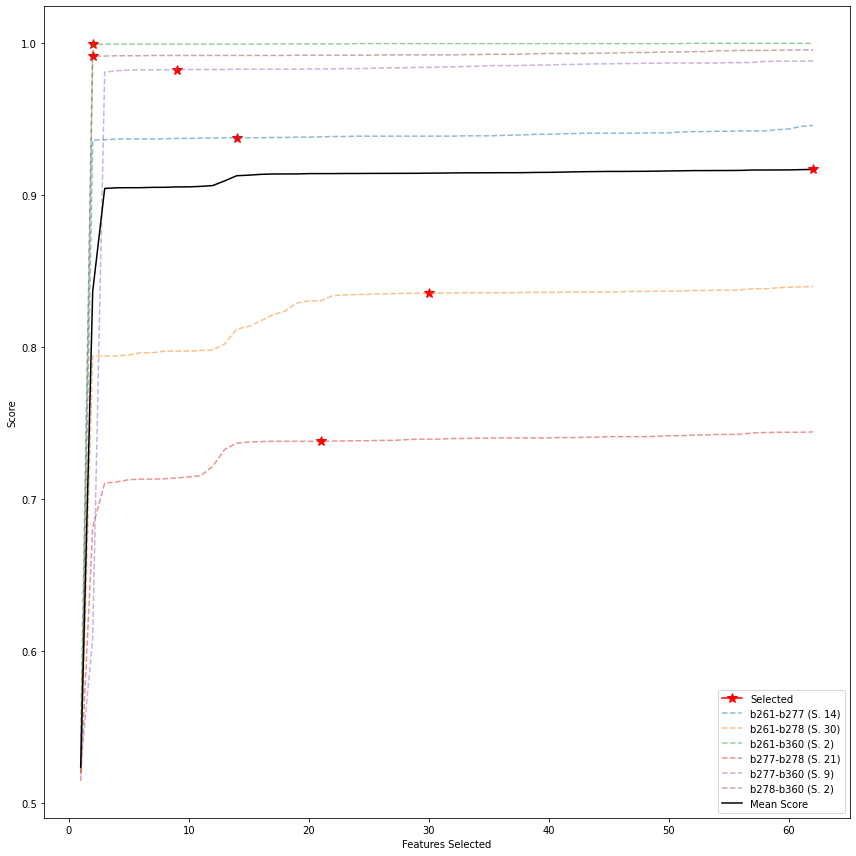

In [57]:
fig, ax = plt.subplots(figsize=(12, 12))

selected_label = "Selected"
for key  in sel.keys():
    key = "-".join(key)
    scores = sorted(rdf[f"{key} Score"].values)
    selected = rdf[f"{key} Selected"].sum()
    
    label = f"{key} (S. {selected})"
    
    ax.plot(selected, scores[selected], color="r", marker="*", markersize=10, label=selected_label)
    ax.plot(range(1, len(scores) + 1), scores, alpha=.5, ls="--", label=label)
    
    selected_label = "_no_label_"
    

label = f"Mean Score"
mfeats = range(1, len(scores) + 1)
mscores = sorted(rdf["Mean Score"].values)
plt.plot(mfeats, mscores, label=label, color="k")

amax = np.argmax(mscores)
ax.plot(mfeats[amax], mscores[amax], color="r", marker="*", markersize=10, label=selected_label)
    
ax.set_xlabel("Features Selected")
ax.set_ylabel("Score")

# plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
# plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
plt.tight_layout()
plt.savefig("plots/rfe.pdf")
plt.show()

In [62]:
(14+30+2+21+9+2)/6

13.0

In [69]:
colors = {
    6: "#ccebc5",
    5: "#ccebd9",
    4: "#b3cde3",
    3: "#decbe4",
    2: "#ffffcc",
    1: "#fbb4ae",   
}

def color_selected(row):
    color = colors.get(row["Selected N"])
    if color is not None:
        return pd.Series(f'background-color: {color}; color: black', row.index)
    
    return pd.Series('', row.index)

resume = rdf[rdf.columns[(
    rdf.columns.str.endswith(" Selected") | 
    rdf.columns.str.startswith("Feature") |
    rdf.columns.str.startswith("Selected N"))]
].sort_values("Selected N", ascending=False).reset_index(drop=True)

html = resume.style.apply(color_selected, axis=1)
html

,Feature,b261-b277 Selected,b261-b278 Selected,b261-b360 Selected,b277-b278 Selected,b277-b360 Selected,b278-b360 Selected,Selected N
0,n09_hk_color,True,True,True,True,True,True,6
1,c89_hk_color,True,True,True,True,True,True,6
2,c89_m2,True,True,False,True,True,False,4
3,n09_m4,True,True,False,True,True,False,4
4,n09_m2,True,True,False,True,True,False,4
5,n09_jh_color,True,True,False,True,True,False,4
6,c89_m4,True,True,False,True,True,False,4
7,c89_jh_color,True,True,False,True,True,False,4
8,n09_jk_color,True,True,False,True,False,False,3
9,n09_c3,True,True,False,True,False,False,3


In [96]:
rfe_ensemble6 = resume[resume["Selected N"] >= 6].Feature.values
rfe_ensemble4 = resume[resume["Selected N"] >= 4].Feature.values
rfe_ensemble3 = resume[resume["Selected N"] >= 3].Feature.values
rfe_ensemble2 = resume[resume["Selected N"] >= 2].Feature.values

In [82]:
def execute_kfold(*, clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = {
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)}    
    return result

In [83]:
_, sdata, _ = dataset.load_tile_clf()
del _

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2") 
svcl_params = BEST_PARAMS["svc_linear"].best_params_
svcl_params

{'C': 100, 'kernel': 'linear', 'probability': True}

In [85]:
%%time
def split_feats(rdf, ta, tb):
    key = f"{ta}-{tb} Selected"
    df = rdf[["Feature", key]]
    
    all_feats = df["Feature"].values
    selected = df[df[key] == True]["Feature"].values
    no_selected = df[df[key] == False]["Feature"].values
    
    return all_feats, selected, no_selected

fname = "results/rfe_vs_notrfe_vs_allf.pkl.bz2"
if os.path.exists(fname):
    buff = joblib.load(fname)
else:
    buff = {}

keys = rdf.columns[rdf.columns.str.endswith(" Selected")].values
for tiles in keys:
    tile_a, tile_b = tiles.split()[0].split("-")
    print("Starting:", tile_a, tile_b)
    if (tile_a, tile_b) not in buff:
        buff[(tile_a, tile_b)] = {}
    
    sample = pd.concat([sdata[tile_a], sdata[tile_b]])
    
    all_feats, selected, no_selected = split_feats(rdf, tile_a, tile_b)
    
    print(dt.datetime.now(), "CLF")
    if "full" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=all_feats, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["full"] = clf
        joblib.dump(buff, fname, compress=3)
        
    print(dt.datetime.now(), "RFE")
    if "rfe" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=selected, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["rfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    print(dt.datetime.now(), "NOT-RFE")
    if "nrfe" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=no_selected, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["nrfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    for ensn in [2, 3, 4, 6]:
        ekey = f"rfe_e{ensn}"
        print(dt.datetime.now(), f"RFE Ensemble {ensn}")
        
        if ekey not in buff[(tile_a, tile_b)]:
            clf = execute_kfold(
                clf_name="SVM-Linear", 
                clasificator=SVC(**svcl_params), 
                sample=sample, X_columns=ecolumns, y_column="cls", nfolds=5)
            buff[(tile_a, tile_b)]["ekey"] = clf
            joblib.dump(buff, fname, compress=3)
        
    print(dt.datetime.now(), "RFE Ensemble 3")
    if "rfe_e3" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=rfe_ensemble3, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["rfe_e3"] = clf
        joblib.dump(buff, fname, compress=3)
    
    print("-" * 20)
    

Starting: b261 b277
2020-08-28 19:11:14.280833 CLF
2020-08-28 19:11:14.281019 RFE
2020-08-28 19:11:14.281087 NOT-RFE
2020-08-28 19:11:14.281152 RFE Ensemble 2
2020-08-28 19:11:14.281216 RFE Ensemble 3
--------------------
Starting: b261 b278
2020-08-28 19:11:14.298527 CLF
2020-08-28 19:11:14.298716 RFE
2020-08-28 19:11:14.298784 NOT-RFE
2020-08-28 19:11:14.298850 RFE Ensemble 2
2020-08-28 19:11:14.298915 RFE Ensemble 3
--------------------
Starting: b261 b360
2020-08-28 19:11:14.314029 CLF
2020-08-28 19:11:14.314789 RFE
2020-08-28 19:11:14.314879 NOT-RFE
2020-08-28 19:11:14.314948 RFE Ensemble 2
2020-08-28 19:11:14.315015 RFE Ensemble 3
--------------------
Starting: b277 b278
2020-08-28 19:11:14.327869 CLF
2020-08-28 19:11:14.328054 RFE
2020-08-28 19:11:14.328122 NOT-RFE
2020-08-28 19:11:14.328187 RFE Ensemble 2
2020-08-28 19:11:14.328252 RFE Ensemble 3
--------------------
Starting: b277 b360
2020-08-28 19:11:14.341533 CLF
2020-08-28 19:11:14.341718 RFE
2020-08-28 19:11:14.341787 NOT

In [87]:
nn

'Full'

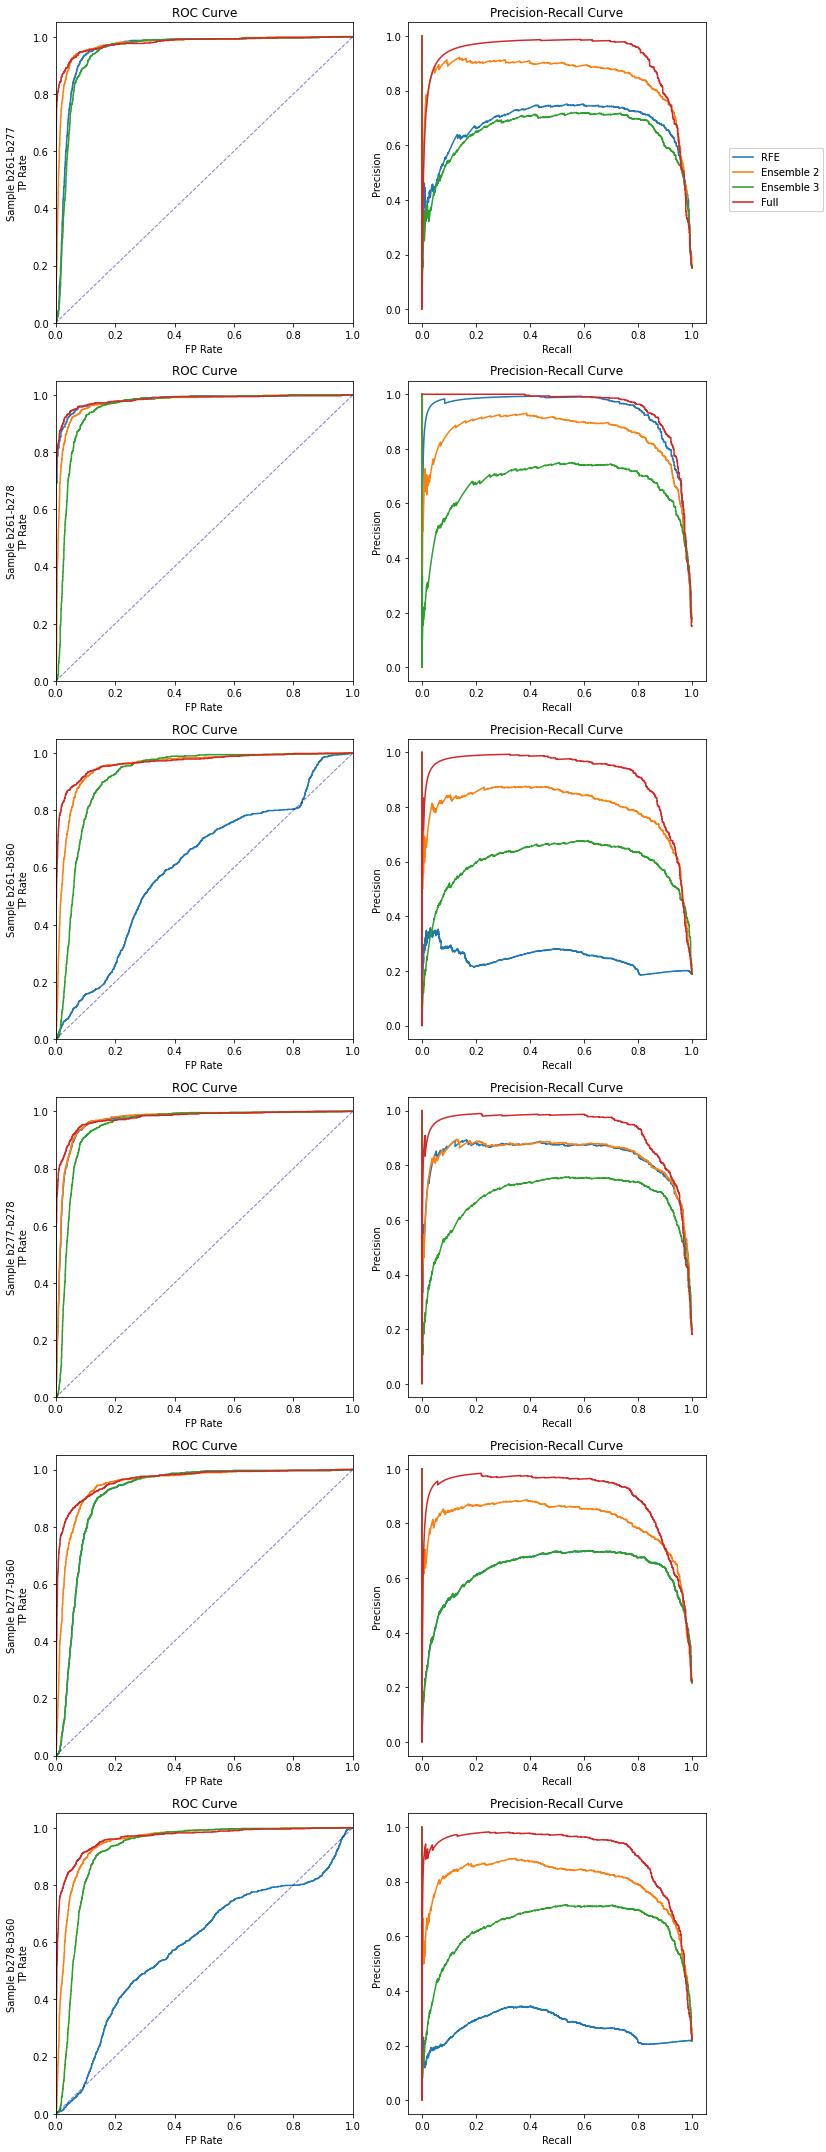

In [89]:
def roc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True):
    if ax == None:
        ax = plt.gca()
        
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    

labels = True
    
HNAMES = [
    ("RFE", "rfe"),
    ("Ensemble 2", "rfe_e2"),
    ("Ensemble 3", "rfe_e3"),
#     ("No-RFE", "nrfe"), 
    ("Full", "full")
]

    
fig, axs = plt.subplots(6, 2, figsize=(10, 5*6))
axs = iter(axs)
for k, sr in buff.items():
    ax = next(axs)
    results = []
    for nn, dat in HNAMES:
        
        dat = Container(sr[dat])
        dat.clf_name = nn
        results.append(dat)
        
    roc(results, ax=ax[0], labels=labels)
    prc(results, ax=ax[1], labels=False)
    labels = False
    y_label = f"Sample {'-'.join(k)}\n{ax[0].get_ylabel()}"
    
    ax[0].set_ylabel(y_label)

    lgd = fig.legend(bbox_to_anchor=(1.15, 0.93))
    fig.tight_layout();

# fig.savefig("plots/rfe_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
rows = []
for r in results:
    prec = metrics.precision_score(r.real_cls, r.predictions)
    rec = metrics.recall_score(r.real_cls, r.predictions)
    rows.append({"Model": r.clf_name, "Precision": prec, "Recall": rec, "AUC": r.roc_auc})
resume = pd.DataFrame(rows)
resume

In [ ]:
print(resume.to_latex(index=False, float_format="%.3f"))